In [20]:
import cv2
import time
import torch
from torchvision import transforms
from plotting_tools import plot_skeletons 
import matplotlib.pyplot as plt
import json

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

import numpy as np

In [21]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def load_model():
    model = torch.load('./yolov7-w6-pose.pt', map_location=device)['model']
    # Put in inference mode
    model.float().eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)
    return model

model = load_model()

cuda:0


In [9]:
def run_inference(image):
    # Resize and pad image
    image = letterbox(image, 960, stride=64, auto=True)[0] # shape: (567, 960, 3)
    # Apply transforms
    image = transforms.ToTensor()(image) # torch.Size([3, 567, 960])
    if torch.cuda.is_available():
      image = image.half().to(device)
    # Turn image into batch
    image = image.unsqueeze(0) # torch.Size([1, 3, 567, 960])
    with torch.no_grad():
      output, _ = model(image)
    return output, image

In [10]:
landmarks = []
def draw_keypoints(output, image):
    global landmarks
    output = non_max_suppression_kpt(output, 
                                     0.25, # Confidence Threshold
                                     0.65, # IoU Threshold
                                     nc=model.yaml['nc'], # Number of Classes
                                     nkpt=model.yaml['nkpt'], # Number of Keypoints
                                     kpt_label=True)
    with torch.no_grad():
        output = output_to_keypoint(output)

    landmarks += [output]

    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx in range(output.shape[0]):
        plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)

    return nimg

In [16]:
def pose_estimation_video(**kwargs):
    global fps_array
    cap = None
    if 'cap' in kwargs:
        d = kwargs['cap']
        if d == 'cam':
            cap = cv2.VideoCapture(0)
        else:
            cap = cv2.VideoCapture(d)

    # VideoWriter for saving the video

    frame_count = 0
    start_time = time.time()

    while cap.isOpened():
        (ret, frame) = cap.read()
        if ret == True:
            frame = cv2.resize(frame, (0,0), fx = 0.8, fy = 0.9)

            frame = cv2.GaussianBlur(frame, (5,5), 3)



            output, frame = run_inference(frame)
            frame = draw_keypoints(output, frame)

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


            cv2.imshow('Pose estimation', frame)

            processing_time = time.time() - start_time

            # Calculate the current FPS
            frame_count += 1
            fps = frame_count / (time.time() - start_time)
            frame_count = 0
            start_time = time.time()
            fps_array += [fps]



            # frame = cv2.resize(frame, (int(cap.get(3)), int(cap.get(4))))
        else:
            break

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


    with open('current_landmarks.json', 'w') as f:
        cleaned = []
        for l in landmarks:
            cleaned.append([m for m in list(l[0]) if len(l) ])
        
        f.write(json.dumps(cleaned, indent=1))
        f.close()

In [24]:
fps_array = []
pose_estimation_video(cap = 'cam')
fps_array = fps_array[1:]
# pose_estimation_image('/home/g/Pictures/yomm.png')


In [25]:
fps_array

[5.1107542263629515,
 5.549995964172437,
 5.566391729318319,
 5.511836974990899,
 5.475213855960358,
 5.423538052529767,
 5.404703581097537,
 5.4509070540853495,
 5.519903244188663,
 5.4807443027388665,
 5.62392179105038,
 5.039601378881107,
 5.483151707837436,
 5.499377857495932,
 5.471514054145017,
 5.417912433556587,
 5.438510002943377,
 5.391524325658402,
 5.475764253710299,
 5.578525960743005,
 5.4669497700111185,
 5.5429474607898594]

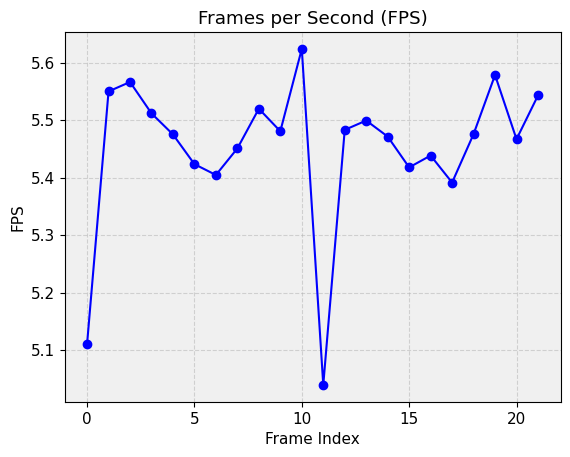

In [26]:
%matplotlib inline
frame_indices = range(len(fps_array))
fig, ax = plt.subplots()
ax.plot(frame_indices, fps_array, color='blue', marker='o', linestyle='-')
ax.set_xlabel('Frame Index')
ax.set_ylabel('FPS')
ax.set_title('Frames per Second (FPS)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_facecolor('#f0f0f0')
plt.show()